## Mercedez Benz Greener Manufacturing
### Predicting Vehicle Testing Time

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import BayesianRidge

from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator

from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

#### Load the data and analyze

In [78]:
use_grid_search = False
num_pca_components = 50
rawdata  = pd.read_csv("train.csv", header=0, sep=",")
rawdata.info()
#rawdataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


/home/justin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


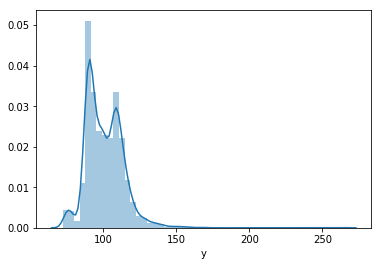

In [41]:
sns.distplot(rawdataset["y"])

### Separate Y labels from the dataframe

In [79]:
y_labels = rawdata["y"].copy()
rawdata = rawdata.drop(["ID", "y"], axis=1)

In [43]:
# check if any columns contain atleast one NaN value
rawdata.columns[rawdata.isna().any()].tolist()
#
# There are no NaNs to deal with.
# NEXT - deal with string type categorical variables 

#rawdata.dtype(rawdata.columns[0])
#rawdata.dtypes.reset_index()

#
# Find object type columns in the dataset
#
object_columns=[]
for col in rawdata.columns:
    if (rawdata[col].dtype == 'object'):
        object_columns.append(col)

print(object_columns)
#
# ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'] are object type columns
# 

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


### Encoding Categorical variables
#### Next steps are to transform string type categorical variables to numerical and binary types
- First, encode them into numerical values
- Then use one-hot-encoding to convert them to binary and keep them in respective dataframes
- Append theose dataframes into the original dataset
- Drop original string categorical variables

In [80]:

dfx0 = pd.get_dummies(rawdata['X0'],prefix='X0_')
dfx1 = pd.get_dummies(rawdata['X1'],prefix='X1_')
dfx2 = pd.get_dummies(rawdata['X2'],prefix='X2_')
dfx3 = pd.get_dummies(rawdata['X3'],prefix='X3_')
dfx4 = pd.get_dummies(rawdata['X4'],prefix='X4_')
dfx5 = pd.get_dummies(rawdata['X5'],prefix='X5_')
dfx6 = pd.get_dummies(rawdata['X6'],prefix='X6_')
dfx8 = pd.get_dummies(rawdata['X8'],prefix='X8_')
dfx = pd.concat([dfx0, dfx1, dfx2, dfx3, dfx4, dfx5, dfx6, dfx8], axis=1)
rawdata = pd.concat([rawdata,dfx], axis=1)

In [81]:
#
# Now that 8 string variables are converted into binary (onehot encoded), 
# drop the base variables. 
# Drop columns ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
#
rawdata = rawdata.drop(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], axis=1)
rawdata.shape

(4209, 563)

### Create Train and Test datasets

In [46]:
X_train, X_test, y_train, y_test = train_test_split(rawdata, y_labels, random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3156, 368)
(1053, 368)
(3156,)
(1053,)


### Dataframe rawdata is now ready for PCA. All variables, except Y and ID are binary (0/1)
##### Although PCA on categorical variables is not advised, it is understood that PCA on binary values is equivalent to doing a Multiple Correspondance Analysis. Hence, proceeding with PCA on the dataset.

Text(0.5,1,'Correlation between different features')

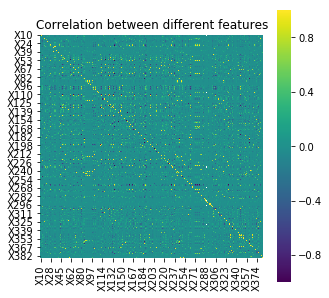

In [73]:
correlation = rawdata.corr()
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(correlation, square=True,cmap='viridis', ax=ax)
plt.title('Correlation between different features')

Text(0,0.5,'Cumulative explained variance')

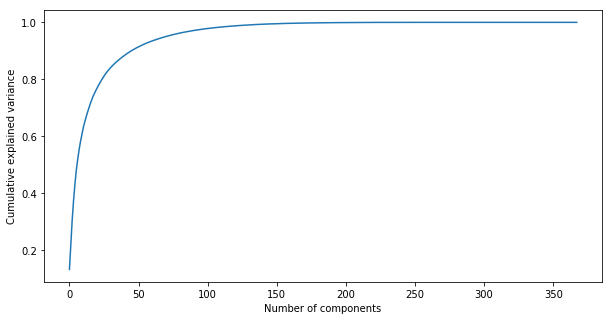

In [82]:
pca = PCA().fit(X_train)
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0,0.5,'Cumulative explained variance')

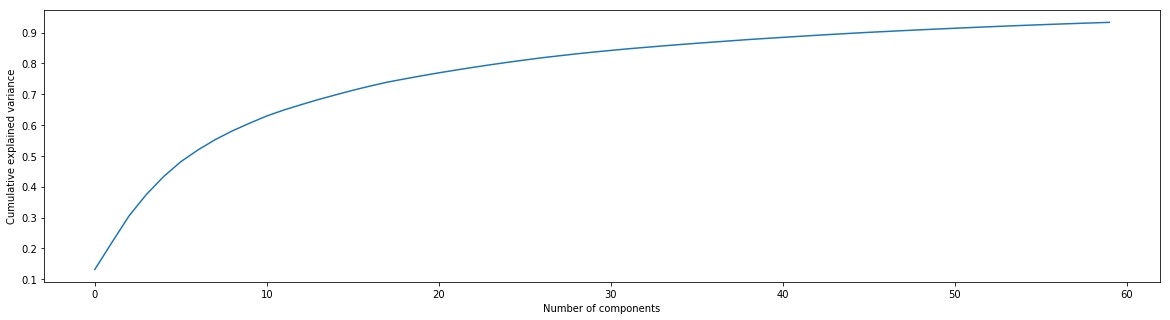

In [49]:
pca = PCA().fit(X_train)
plt.figure(figsize=(20,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_[0:60]))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
#plt.annotate('20',xy=(15, .90))

The cumulative explained variance increases slowly and approaches 90% when the number of components becomes 50. Hence, proceeding with 50 components.

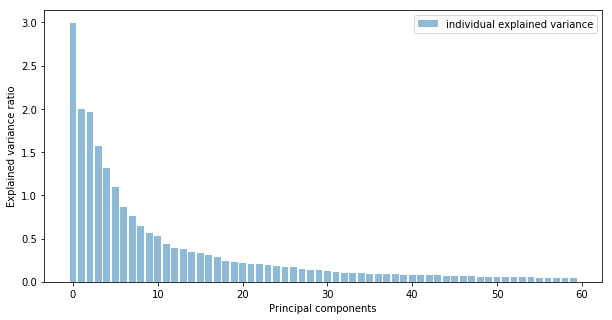

In [50]:
# individual explained variance
plt.figure(figsize=(10, 5))

plt.bar(range(60), pca.explained_variance_[0:60], alpha=0.5,  label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

In [51]:
#consider first 50 components as they are explaining more than 90% of variation in the data
x_pca = PCA(n_components=num_pca_components)
#transform training set X values using 15 component PCA
x_train_pca = x_pca.fit_transform(X_train)

Text(0.5,1,'Correlation between features after PCA')

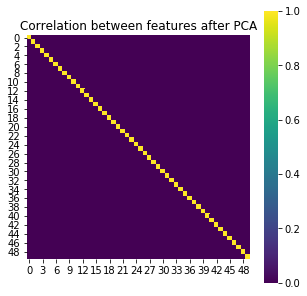

In [83]:
x_train_pca_df = pd.DataFrame(x_train_pca)
pca_correlation = x_train_pca_df.corr()
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pca_correlation, square=True,cmap='viridis', ax=ax)
plt.title('Correlation between features after PCA')

#### Function to calculate RSquared Value

In [53]:
#
# Calculate R Squared  R2 = 1-(SSE/SST)
#    SSE = SUM( (y_actual - y_pred)^2 )  -- sum of squared errors of our regression model
#    SST = SUM( (y_actual - y_mean)^2 )  -- sum of squared errors of our baseline model

def calc_r2(y_test, y_pred_final):
    y = pd.DataFrame({"y_actual": y_test, "y_pred":y_pred_final})
    y["y_mean"] = np.mean(y_test)
    y["sse_i"] = (y["y_actual"] - y["y_pred"])**2
    y["sst_i"] = (y["y_actual"] - y["y_mean"])**2
    sse = y["sse_i"].sum()
    sst = y["sst_i"].sum()
    y.head() 
    #print(sse)
    #print(sst)
    r2 = 1 - (sse/sst)
    print(r2)
    return r2

### Now Build the model using chosen Regression algorithm
#### Use x_train_pca and y_train as X and Y variables

In [54]:
# transform the test data set using the same PCA object(15 components)
x_test_pca = x_pca.fit_transform(X_test)

### Linear Regression

In [55]:
linreg = LinearRegression()
linreg.fit(x_train_pca, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
# Predict for the test data set
y_pred_lr = linreg.predict(x_test_pca)

### Lasso, Ridge and ElasticNet

In [57]:
lasso = Lasso()
ridge = Ridge()
elastic = ElasticNet()

lasso.fit(x_train_pca, y_train)
ridge.fit(x_train_pca, y_train)
elastic.fit(x_train_pca, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### Predict using Lasso, Ridge and ElasticNet

In [58]:
y_pred_lasso =  lasso.predict(x_test_pca)
y_pred_ridge =  ridge.predict(x_test_pca)
y_pred_elastic =  elastic.predict(x_test_pca)


#### Bayesian Ridge Regression

In [59]:
nbr = BayesianRidge(compute_score=True)
nbr.fit(x_train_pca, y_train)
y_pred_nbr = nbr.predict(x_test_pca)


### Support Vector Machine Regression

In [60]:
svreg = SVR(C=1.0, epsilon=0.1)
svreg.fit(x_train_pca, y_train)
y_pred_svr = svreg.predict(x_test_pca)

### RandomForest Regression
#### Using GridSearch to identify optimal hyper paramaters

In [61]:
#
if(use_grid_search == True):
    rf_params = {"n_estimators":[30,40,50],"max_depth":[7,8,9,10],"max_leaf_nodes":[25,30,40]}

    #RF instance
    rfreg = RandomForestRegressor()

    rf_grid = GridSearchCV(rfreg, rf_params, cv=5)
    rf_grid_model = rf_grid.fit(x_train_pca,y_train)

    rf_grid.best_params_

    # Now predict using random forest grid model
    y_pred_rf = rf_grid_model.predict(x_test_pca)

#Result : {'max_depth': 8, 'max_leaf_nodes': 30, 'n_estimators': 50}

In [62]:
rfreg = RandomForestRegressor(max_depth=8, max_leaf_nodes=30,n_estimators=50, random_state=0)
rfreg.fit(x_train_pca,y_train)
y_pred_rf = rfreg.predict(x_test_pca)

### Try XGBoost

In [63]:
#specify xgboost parameters
xgb_params = {
    "n_trees": 600,
    "eta":0.0025,
    "max_depth":5,
    "subsample":0.85,
    "objective":"reg:linear",
    "eval_metric":"rmse",
    "base_score":np.mean(y_train)
}

dtrain = xgb.DMatrix(x_train_pca, y_train)
dtest  = xgb.DMatrix(x_test_pca)
num_boosting_rounds = 1500

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=num_boosting_rounds)
y_pred_xgb = xgb_model.predict(dtest)

rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgb))
r2_xgb = calc_r2(y_test.values, y_pred_xgb)

0.38898136697500374


### Try Stacked Model Pipeline

#### Stacked Model: RandomForest on ElasticNet

In [64]:
model_stack_rf = make_pipeline(StackingEstimator(estimator=ElasticNetCV(l1_ratio=[0.8, 0.9,0.95, 0.99],tol=1e-05)), RandomForestRegressor(max_depth=6, max_leaf_nodes=50,n_estimators=500, bootstrap=False)) 
model_stack_rf.fit(x_train_pca, y_train)
y_pred_stack_rf = model_stack_rf.predict(x_test_pca)
r2_stack_rf = calc_r2(y_test.values, y_pred_stack_rf)

0.1428627494946405


In [65]:
y_pred_final1 = y_pred_stack_rf * (0.5/2) + y_pred_rf * (1.5/2) 
r2_final1 = calc_r2(y_test.values, y_pred_final1)
r2_final1

0.4162230811149734


0.4162230811149734

#### Stacked Model: ExtraTreesForest on ElasticNet

In [66]:
model_stack_et = make_pipeline(StackingEstimator(estimator=ElasticNetCV(l1_ratio=[0.8, 0.9,0.95, 0.99],tol=1e-05)), \
                               ExtraTreesRegressor(n_estimators=500, bootstrap=False)) 
model_stack_et.fit(x_train_pca, y_train)
y_pred_stack_et = model_stack_et.predict(x_test_pca)
r2_stack_et = calc_r2(y_test.values, y_pred_stack_et)

0.3456001646521224


In [67]:
y_pred_final2 = y_pred_stack_et * (0.5/2) + y_pred_rf * (1.5/2) 

r2_final2 = calc_r2(y_test.values, y_pred_final2)
r2_final2

0.4254832702919116


0.4254832702919116

## Evaluate the models
#### We have predicted y values resulting from multiple regression models. Compare all of them on RMSE, MAE and RSquared 

#### Compute Null RMSE
###### Calculate the RMS error of test Y labels against the mean of y labels. Predicted Y labels must have similar or better error
Null RMSE shows by how much the test data set y labels vary from their own mean value.

In [68]:
#Compute null RMSE - 
# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)
# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
null_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_null))
print("Null RMSE: " +  str(null_rmse))

Null RMSE: 12.603966305119242


#### Calculate RMSE, MAE and R Squared for predictions using linear regression as well as Random Forest

In [69]:
algorithm = ["Linear Model", "Lasso", "Ridge", "ElasticNet", "Random Forest", "Support Vector Regression", "XGBoost", "Stacked Model RF", "Stacked Model ET", "Combination1 - RF,ElasticNet", "Combination2 - RF, ExtraTrees", "Bayesian Ridge"]
errors = pd.DataFrame(algorithm, columns=["Model"])

errors["Null-RMSE"] = null_rmse
errors["RMSE"] = 0
errors["MAE"] = 0
errors["RSquared"] = 0

errors.iloc[0,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_lr))
errors.iloc[1,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso))
errors.iloc[2,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_ridge))
errors.iloc[3,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_elastic))
errors.iloc[4,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_rf))
errors.iloc[5,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_svr))
errors.iloc[6,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgb))
errors.iloc[7,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_stack_rf))
errors.iloc[8,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_stack_et))
errors.iloc[9,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_final1))
errors.iloc[10,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_final2))
errors.iloc[11,2] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_nbr))

errors.iloc[0,3] = metrics.mean_absolute_error(y_test,y_pred_lr)
errors.iloc[1,3] = metrics.mean_absolute_error(y_test,y_pred_lasso)
errors.iloc[2,3] = metrics.mean_absolute_error(y_test,y_pred_ridge)
errors.iloc[3,3] = metrics.mean_absolute_error(y_test,y_pred_elastic)
errors.iloc[4,3] = metrics.mean_absolute_error(y_test,y_pred_rf)
errors.iloc[5,3] = metrics.mean_absolute_error(y_test,y_pred_svr)
errors.iloc[6,3] = metrics.mean_absolute_error(y_test,y_pred_xgb)
errors.iloc[7,3] = metrics.mean_absolute_error(y_test,y_pred_stack_rf)
errors.iloc[8,3] = metrics.mean_absolute_error(y_test,y_pred_stack_et)
errors.iloc[9,3] = metrics.mean_absolute_error(y_test,y_pred_final1)
errors.iloc[10,3] = metrics.mean_absolute_error(y_test,y_pred_final2)
errors.iloc[11,3] = metrics.mean_absolute_error(y_test,y_pred_nbr)

errors.iloc[0,4] = np.round(linreg.score(x_test_pca, y_test)*100,2)
errors.iloc[1,4] = np.round(lasso.score(x_test_pca, y_test)*100,2)
errors.iloc[2,4] = np.round(ridge.score(x_test_pca, y_test)*100,2)
errors.iloc[3,4] = np.round(elastic.score(x_test_pca, y_test)*100,2)
errors.iloc[4,4] = np.round(rfreg.score(x_test_pca, y_test)*100,2)
errors.iloc[5,4] = np.round(svreg.score(x_test_pca, y_test)*100,2)
errors.iloc[6,4] = np.round(r2_xgb*100, 2)
errors.iloc[7,4] = np.round(r2_stack_rf*100, 2)
errors.iloc[8,4] = np.round(r2_stack_et*100, 2)
errors.iloc[9,4] = np.round(r2_final1*100, 2)
errors.iloc[10,4] = np.round(r2_final2*100, 2)
errors.iloc[11,4] = np.round(nbr.score(x_test_pca, y_test)*100,2)

#errors.sort_values(["RMSE", "RSquared"], ascending=False)
errors

,Model,Null-RMSE,RMSE,MAE,RSquared
0,Linear Model,12.603966,10.977665,8.021208,24.14
1,Lasso,12.603966,10.807772,7.934880,26.47
2,Ridge,12.603966,10.975871,8.019529,24.17
3,ElasticNet,12.603966,10.932992,8.087122,24.76
4,Random Forest,12.603966,9.826961,6.977092,39.21
5,Support Vector Regression,12.603966,10.604455,7.370170,29.21
6,XGBoost,12.603966,9.852228,7.019464,38.90
7,Stacked Model RF,12.603966,11.668967,8.069630,14.29
8,Stacked Model ET,12.603966,10.195976,7.352537,34.56
9,"Combination1 - RF,ElasticNet",12.603966,9.630098,6.739024,41.62
